In [38]:
import keras
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [39]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [40]:
%%time
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'output-folder/'

train_dir = os.path.join(base_dir, 'training')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,3))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='categorical')

    i = 0
    for inputs_batch, labels_batch in generator:
#         print(labels_batch)
#         print(inputs_batch)
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 100)
validation_features, validation_labels = extract_features(validation_dir,20)
test_features, test_labels = extract_features(test_dir, 20)

print(test_features.shape)
print(test_labels.shape)
print(test_features)

Found 169 images belonging to 3 classes.
Found 52 images belonging to 3 classes.
Found 56 images belonging to 3 classes.
(20, 4, 4, 512)
(20, 3)
[[[[  1.49898291e-01   0.00000000e+00   5.70220053e-02 ...,
      0.00000000e+00   9.99690056e-01   0.00000000e+00]
   [  4.86486971e-01   0.00000000e+00   3.82738680e-01 ...,
      0.00000000e+00   6.00962579e-01   0.00000000e+00]
   [  2.73944855e-01   0.00000000e+00   4.49480593e-01 ...,
      5.71432114e-02   8.56729388e-01   0.00000000e+00]
   [  1.69984221e-01   0.00000000e+00   1.61142170e-01 ...,
      1.97799236e-01   1.29125929e+00   0.00000000e+00]]

  [[  6.43842816e-01   0.00000000e+00   3.54903907e-01 ...,
      0.00000000e+00   1.04896355e+00   0.00000000e+00]
   [  5.93129516e-01   0.00000000e+00   1.50256467e+00 ...,
      0.00000000e+00   3.53370905e-01   0.00000000e+00]
   [  2.17521608e-01   0.00000000e+00   1.46788692e+00 ...,
      1.70550942e-02   3.30284834e-01   0.00000000e+00]
   [  6.42242879e-02   0.00000000e+00   5

In [41]:
%%time
print(test_labels[0:20])
from keras.utils import to_categorical
test_labels = to_categorical(test_labels, 3)

[[ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]]
CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 105 ms


In [42]:
print(test_labels.shape)

(20, 3, 3)


In [43]:
train_features = np.reshape(train_features ,(100,4 * 4 * 512))
validation_features = np.reshape(validation_features, (20, 4 * 4 * 512))
test_features = np.reshape(test_features, (20, 4 * 4 * 512))

In [44]:
%%time
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=50,
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels))

Train on 100 samples, validate on 20 samples
Epoch 1/50
100/100 [==============================] - 1s 13ms/step - loss: 1.2412 - acc: 0.4400 - val_loss: 0.9801 - val_acc: 0.6000
Epoch 2/50
100/100 [==============================] - 0s 3ms/step - loss: 1.0761 - acc: 0.4800 - val_loss: 0.9265 - val_acc: 0.6500
Epoch 3/50
100/100 [==============================] - 0s 3ms/step - loss: 1.1269 - acc: 0.4400 - val_loss: 0.8923 - val_acc: 0.6500
Epoch 4/50
100/100 [==============================] - 0s 2ms/step - loss: 0.9627 - acc: 0.5900 - val_loss: 0.8839 - val_acc: 0.7000
Epoch 5/50
100/100 [==============================] - 0s 2ms/step - loss: 0.9791 - acc: 0.5100 - val_loss: 0.8733 - val_acc: 0.7500
Epoch 6/50
100/100 [==============================] - 0s 2ms/step - loss: 0.8960 - acc: 0.5200 - val_loss: 0.8656 - val_acc: 0.7500
Epoch 7/50
100/100 [==============================] - 0s 2ms/step - loss: 1.0018 - acc: 0.3900 - val_loss: 0.8522 - val_acc: 0.7000
Epoch 8/50
100/100 [==========

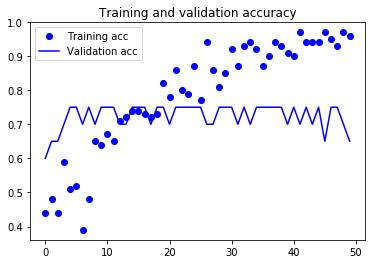

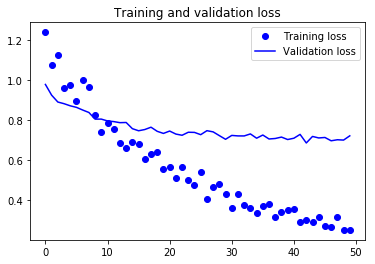

In [45]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

model.save('digital.h5')

In [46]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 771       
Total params: 16,812,867
Trainable params: 16,812,867
Non-trainable params: 0
_________________________________________________________________


In [48]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

('This is the number of trainable weights before freezing the conv base:', 30)
('This is the number of trainable weights after freezing the conv base:', 4)


In [49]:


%%time
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=0,
      width_shift_range=0,
      height_shift_range=0,
      shear_range=0,
      zoom_range=0,
      horizontal_flip=False,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

#history = model.fit_generator(
      #train_generator,
      #steps_per_epoch=100,
      #epochs=30,
      #validation_data=validation_generator,
      #validation_steps=50,
      #verbose=2)



Found 169 images belonging to 3 classes.
Found 52 images belonging to 3 classes.
CPU times: user 168 ms, sys: 28 ms, total: 196 ms
Wall time: 501 ms


In [50]:
model.save('fireants_01.h5')

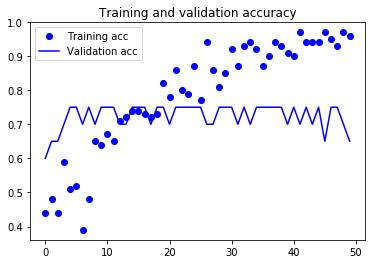

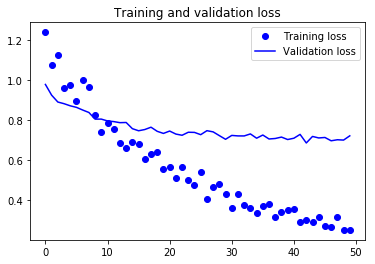

In [51]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [52]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [53]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [54]:
%%time
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=10, # 100
      epochs=10, # 100
      validation_data=validation_generator,
      validation_steps=15 ) # 50

Epoch 1/10
10/10 [==============================] - 259s 26s/step - loss: 1.0883 - acc: 0.4556 - val_loss: 0.9972 - val_acc: 0.5000
Epoch 2/10
10/10 [==============================] - 242s 24s/step - loss: 0.8545 - acc: 0.6862 - val_loss: 0.9344 - val_acc: 0.5385
Epoch 3/10
10/10 [==============================] - 233s 23s/step - loss: 0.7094 - acc: 0.8155 - val_loss: 0.9134 - val_acc: 0.5769
Epoch 4/10
10/10 [==============================] - 239s 24s/step - loss: 0.5976 - acc: 0.8778 - val_loss: 0.8940 - val_acc: 0.5192
Epoch 5/10
10/10 [==============================] - 239s 24s/step - loss: 0.5155 - acc: 0.8939 - val_loss: 0.8614 - val_acc: 0.5385
Epoch 6/10
10/10 [==============================] - 239s 24s/step - loss: 0.4154 - acc: 0.9397 - val_loss: 0.8163 - val_acc: 0.6346
Epoch 7/10
10/10 [==============================] - 239s 24s/step - loss: 0.3610 - acc: 0.9442 - val_loss: 0.7989 - val_acc: 0.5962
Epoch 8/10
10/10 [==============================] - 240s 24s/step - loss: 0.

In [55]:
model.save('fireants_02.h5')

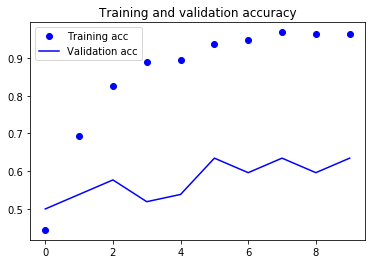

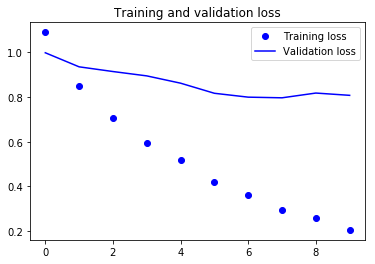

In [56]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

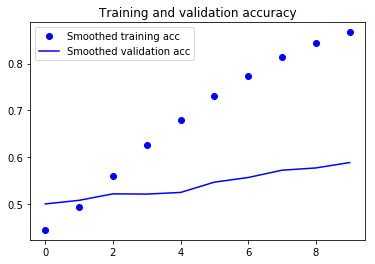

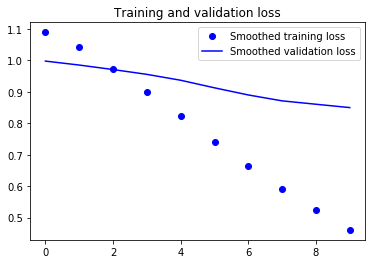

In [57]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [58]:
%%time
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50) # use steps = 50
print('test acc:', test_acc)

Found 56 images belonging to 3 classes.
('test acc:', 0.60790598277862251)
CPU times: user 29min 39s, sys: 49.5 s, total: 30min 29s
Wall time: 7min 44s
